<a href="https://colab.research.google.com/github/ajboyd2/salmon/blob/master/paper_outputs/timing_comparison_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
%pip install salmon-lm
%pip install statsmodels
%pip install rpy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.


# NOTICE
If you are running this notebook on Colab and/or have just installed the packages by executing the previous cell above, you must restart the runtime before continuing. This is because by default an old version of Numpy is already potentially loaded. The only way to swap to the up-to-date version is to restart the runtime.

This can be done by performing the following steps:
1. At the top of the page under `Runtime`, select `Restart Runtime`, then select `Yes`.
2. After the runtime has been restarted, do not rerun the previous cell that installed the packages, and instead continue on down below.


# SALMON - Paper Results

This notebook contains all of the code used to generate the results seen in the paper.

Code used in the paper will be displayed here in corresponding sections.

Toggle `DATAFRAME_AS_LATEX` to showcase resulting `DataFrame` objects as LaTeX or as a native notebook rendering.

Toggle `SAVE_PLOTS` to enable/disable overwriting renderings in `./plots`.

In [3]:
%matplotlib inline

import os

DATAFRAME_AS_LATEX = True
SAVE_PLOTS = True

if not os.path.isdir("./plots"):
    os.mkdir("./plots")
if not os.path.isdir("./tables"):
    os.mkdir("./tables")

def print_dataframe(df, name):
    if "." not in name:
        name += ".tex"
    name = "./tables/" + name
    if DATAFRAME_AS_LATEX:
        latex_output = df.to_latex()
        print(latex_output)
        with open(name, "w") as f:
            f.write(latex_output)
    else:
        print(df)

def handle_plot(fig, name, **kwargs):
    if SAVE_PLOTS:
        if "." not in name:
            name += ".png"
        name = "./plots/" + name
        fig.savefig(name, dpi=150, bbox_inches="tight", **kwargs)
    return

## Section 1.

_no SALMON specific code used_

## Section 2.

In [4]:
from salmon import *
import pandas as pd

if not os.path.isdir("./data"):
    os.mkdir("./data")
if not os.path.isfile("./data/AmesHousing.csv"):
    import urllib.request
    urllib.request.urlretrieve("https://raw.githubusercontent.com/ajboyd2/salmon/master/data/AmesHousing.csv", "./data/AmesHousing.csv")

# shuffle for a good representative 'head' to showcase dataset
full_data = pd.read_csv("./data/AmesHousing.csv").sample(frac=1, random_state=12312).reset_index(drop=True)
full_data = full_data.drop([2438, 1989, 1134, 2775]).reset_index(drop=True)
full_data = full_data.drop([442, 1671]).reset_index(drop=True) # Dropping some extreme outliers

In [5]:
data = full_data[["SalePrice"]].copy()
data.columns = ("Price($)",)
data["Style"] =  full_data["House Style"].apply(lambda x: x.replace("Story", " Story") if x in set(["1Story", "2Story",]) else "Other")
data["Sq. Ft."] = full_data["Gr Liv Area"]
data["Fire?"] = full_data["Fireplace Qu"].apply(lambda x: "No" if pd.isna(x) else "Yes")
print_dataframe(data.head(), "data_head")

\begin{tabular}{lrlrl}
\toprule
{} &  Price(\$) &    Style &  Sq. Ft. & Fire? \\
\midrule
0 &    162000 &  2 Story &     1400 &    No \\
1 &    195000 &  2 Story &     1660 &    No \\
2 &    164000 &    Other &     1646 &   Yes \\
3 &    417500 &  1 Story &     2464 &   Yes \\
4 &    186800 &  1 Story &     1400 &    No \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


In [6]:
x = Q("Sq. Ft.")
y = Q("Price($)")
simple_model = LinearModel(x, y)
print(simple_model)

Price($) ~ 1+Sq. Ft.


In [7]:
no_intercept_model = LinearModel(x - 1, y)
no_intercept_model = LinearModel(x, y, intercept=False)
print(no_intercept_model)

Price($) ~ Sq. Ft.


In [8]:
print_dataframe(simple_model.fit(data), name="simple_model_output")

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &    SE &     t &      p &  2.5\% &  97.5\% \\
\midrule
Sq. Ft.   &        118.5 & 2.068 & 57.33 &  0.000 & 114.5 &  122.6 \\
Intercept &         3614 &  3254 & 1.111 & 0.2668 & -2766 &   9995 \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


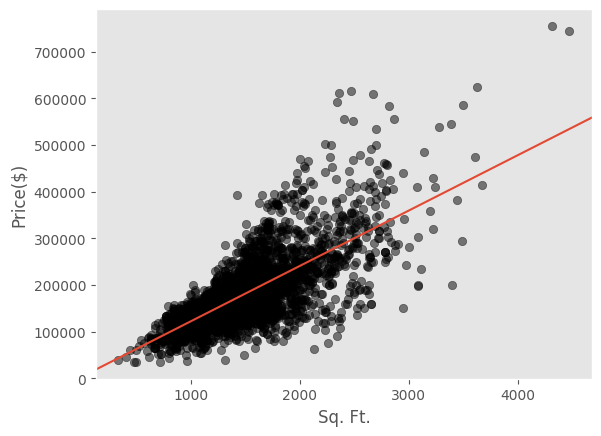

In [9]:
handle_plot(simple_model.plot(), name="simple_model_output")

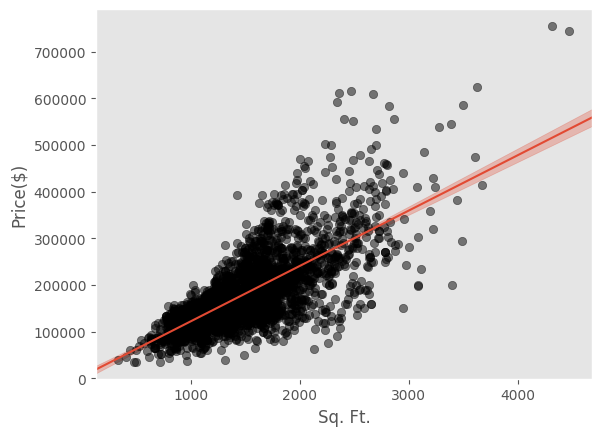

In [10]:
alpha_val = 0.05
handle_plot(simple_model.plot(confidence_band=alpha_val), name="simple_model_output_conf_band")

In [11]:
simple_log_model = LinearModel(Q("Sq. Ft."), Log(Q("Price($)")))
print(simple_log_model)

log(Price($)) ~ 1+Sq. Ft.


In [12]:
print_dataframe(simple_log_model.fit(data), name="simple_log_model_output")

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &       SE &     t &     p &     2.5\% &    97.5\% \\
\midrule
Sq. Ft.   &     5.906e-4 & 1.055e-5 & 55.96 & 0.000 & 5.699e-4 & 6.113e-4 \\
Intercept &        11.14 &   0.0166 & 670.6 & 0.000 &    11.11 &    11.17 \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


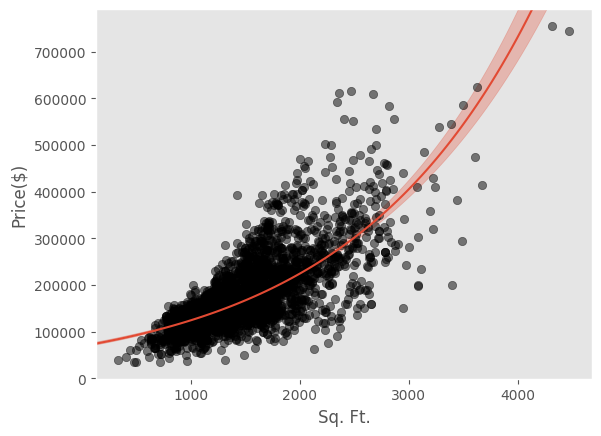

In [13]:
handle_plot(simple_log_model.plot(confidence_band=alpha_val), name="simple_log_model_output")

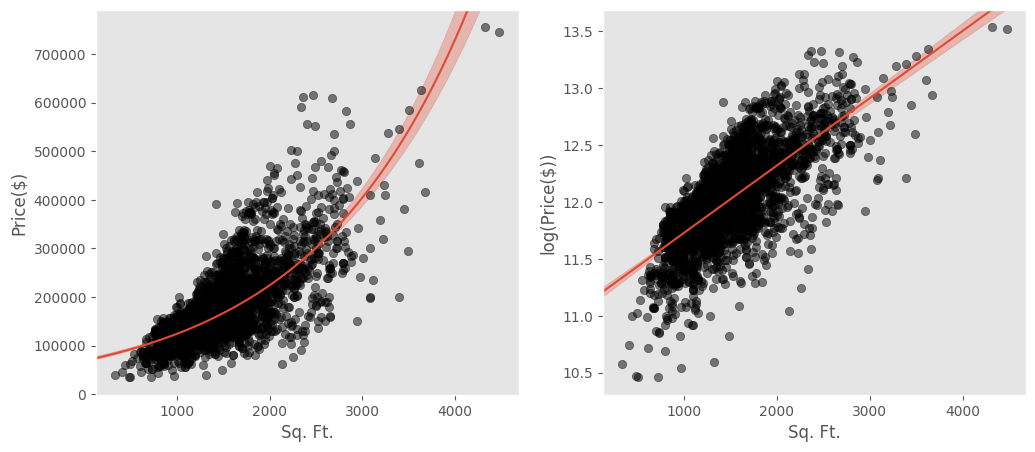

In [14]:
handle_plot(simple_log_model.plot(confidence_band=alpha_val, transformed_y_space=True, figsize=(12, 5)), name="simple_log_model_both_outputs")

In [15]:
poly_model = LinearModel(Poly(Q("Sq. Ft."), 2), Log(Q("Price($)")))
# Poly(Q("Sq. Ft."), 2) is equivalent to Q("Sq. Ft.") + Q("Sq. Ft.") ** 2
print(poly_model)

log(Price($)) ~ 1+Sq. Ft.+Sq. Ft.^2


In [16]:
print_dataframe(poly_model.fit(data), name="poly_model_output")

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &       SE &      t &       p &      2.5\% &     97.5\% \\
\midrule
Sq. Ft.   &     9.989e-4 & 4.603e-5 &  21.70 & 5.9e-97 &  9.087e-4 &    0.0011 \\
Sq. Ft.\textasciicircum 2 &    -1.180e-7 & 1.296e-8 & -9.107 & 1.5e-19 & -1.434e-7 & -9.261e-8 \\
Intercept &        10.82 &   0.0386 &  280.3 &   0.000 &     10.75 &     10.90 \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


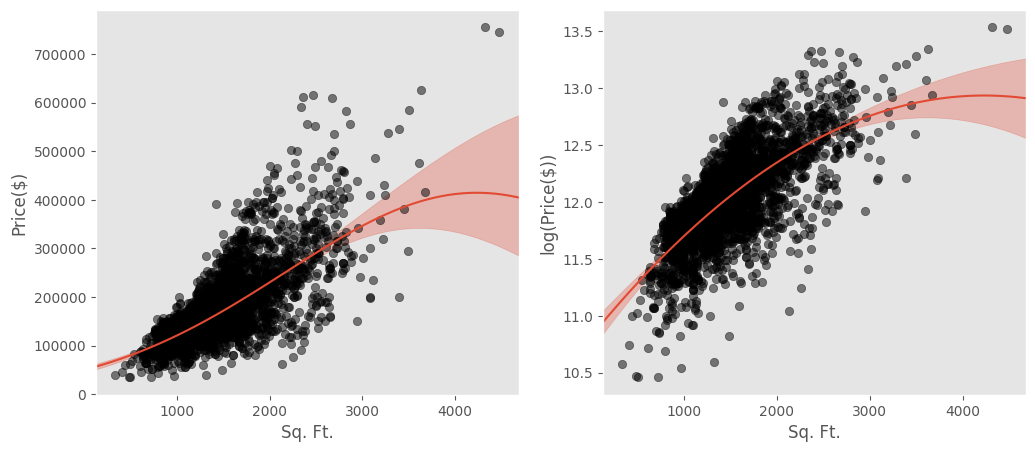

In [17]:
handle_plot(poly_model.plot(confidence_band=alpha_val, transformed_y_space=True, figsize=(12, 5)), name="poly_model_outputs")

In [18]:
simple_cat_model = LinearModel(
    C("Style") + C("Fire?"),
    Log(Q("Price($)")),
)
print(simple_cat_model)

log(Price($)) ~ 1+Fire?+Style


In [19]:
print_dataframe(simple_cat_model.fit(data), name="simple_cat_model_output")

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &     SE &      t &       p &    2.5\% &   97.5\% \\
\midrule
Style\{2 Story\} &       0.1058 & 0.0143 &  7.374 & 2.1e-13 &  0.0777 &  0.1339 \\
Style\{Other\}   &      -0.1500 & 0.0164 & -9.156 & 9.8e-20 & -0.1821 & -0.1179 \\
Fire?\{Yes\}     &       0.3966 & 0.0124 &  31.87 &  1e-191 &  0.3722 &  0.4210 \\
Intercept      &        11.82 & 0.0105 &   1124 &   0.000 &   11.80 &   11.84 \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


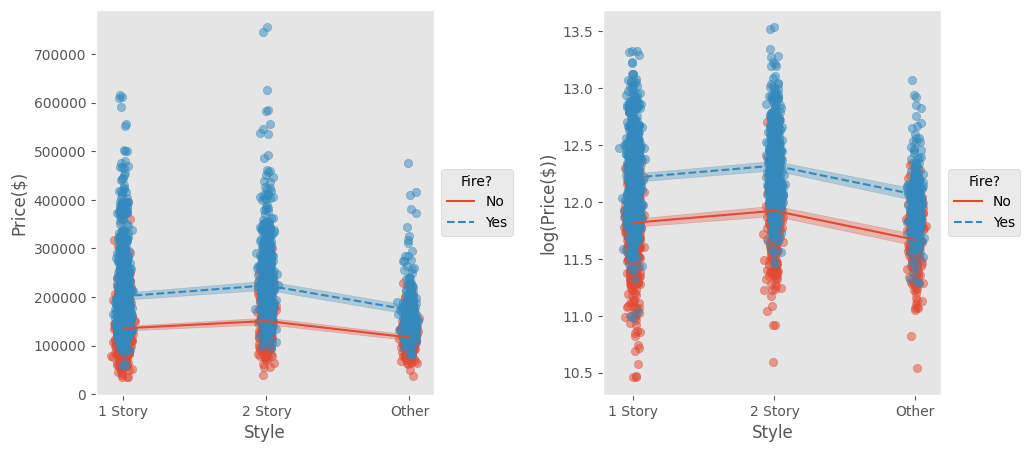

In [20]:
handle_plot(simple_cat_model.plot(confidence_band=alpha_val, transformed_y_space=True, figsize=(12,5)), name="simple_cat_model_output")

In [21]:
house, fire = C("Style"), C("Fire?")
interaction_model = LinearModel(
        house & fire, # or: house + fire + house * fire,
        Log(Q("Price($)")))
print(interaction_model)

log(Price($)) ~ (Fire?)(Style)+1+Fire?+Style


In [22]:
print_dataframe(interaction_model.fit(data), name="interaction_model_output")

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &     SE &       t &        p &    2.5\% &   97.5\% \\
\midrule
Style\{2 Story\}               &       0.1123 & 0.0217 &   5.179 & 2.385e-7 &  0.0698 &  0.1548 \\
Style\{Other\}                 &      -0.0740 & 0.0223 &  -3.318 & 9.181e-4 & -0.1177 & -0.0303 \\
Fire?\{Yes\}                   &       0.4347 & 0.0173 &   25.13 &   3e-126 &  0.4008 &  0.4687 \\
(Style\{2 Story\})(Fire?\{Yes\}) &      -0.0190 & 0.0289 & -0.6593 &   0.5097 & -0.0756 &  0.0376 \\
(Style\{Other\})(Fire?\{Yes\})   &      -0.1638 & 0.0327 &  -5.008 & 5.813e-7 & -0.2280 & -0.0997 \\
Intercept                    &        11.80 & 0.0119 &   987.7 &    0.000 &   11.78 &   11.82 \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


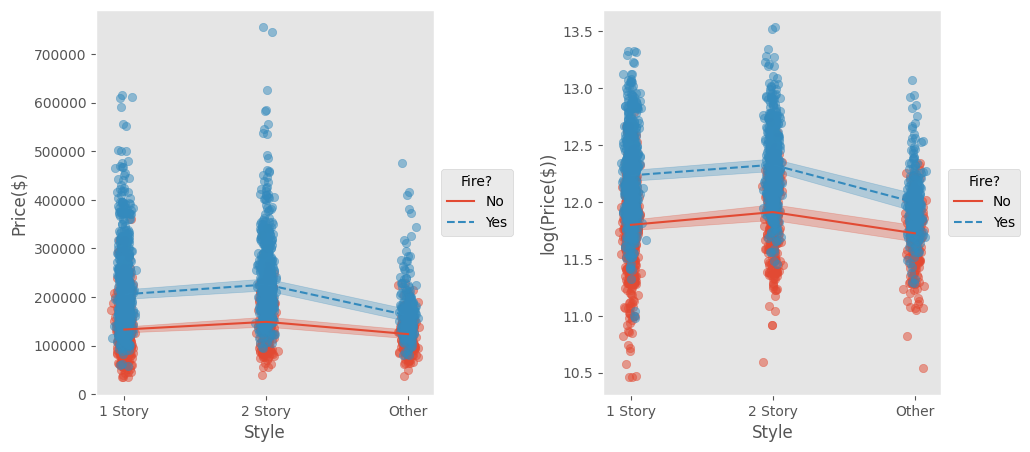

In [23]:
handle_plot(interaction_model.plot(confidence_band=alpha_val, transformed_y_space=True, figsize=(12,5)), name="interaction_model_output")

In [24]:
house, fire, sqft = C("Style"), C("Fire?"), Q("Sq. Ft.")
quant_cat_model = LinearModel(
        (house & fire) + sqft,
        Log(Q("Price($)")))
print(quant_cat_model)

log(Price($)) ~ (Fire?)(Style)+1+Fire?+Sq. Ft.+Style


In [25]:
print_dataframe(quant_cat_model.fit(data), name="quant_cat_model_output")

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &       SE &      t &        p &     2.5\% &    97.5\% \\
\midrule
Style\{2 Story\}               &      -0.1524 &   0.0171 & -8.926 &  7.7e-19 &  -0.1859 &  -0.1189 \\
Style\{Other\}                 &      -0.1535 &   0.0167 & -9.184 &  7.7e-20 &  -0.1863 &  -0.1207 \\
Fire?\{Yes\}                   &       0.2160 &   0.0137 &  15.79 &  5.7e-54 &   0.1892 &   0.2428 \\
(Style\{2 Story\})(Fire?\{Yes\}) &      -0.0389 &   0.0215 & -1.807 &   0.0709 &  -0.0811 &   0.0033 \\
(Style\{Other\})(Fire?\{Yes\})   &      -0.1478 &   0.0244 & -6.057 & 1.564e-9 &  -0.1957 &  -0.1000 \\
Sq. Ft.                      &     5.732e-4 & 1.188e-5 &  48.24 &    0.000 & 5.499e-4 & 5.965e-4 \\
Intercept                    &        11.15 &   0.0161 &  691.6 &    0.000 &    11.12 &    11.18 \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


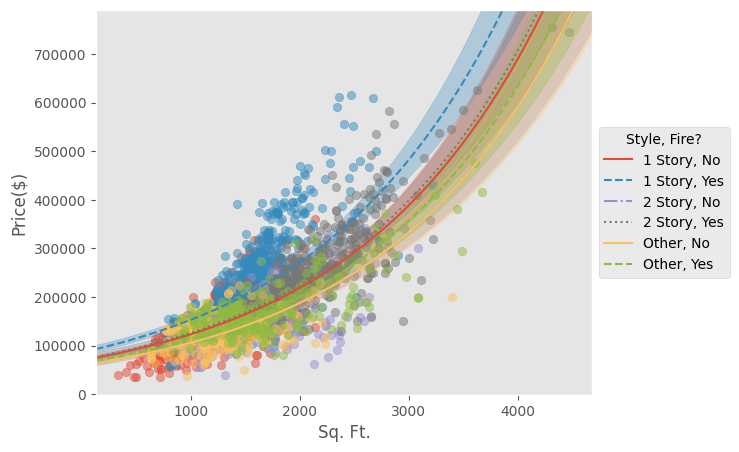

In [26]:
handle_plot(quant_cat_model.plot(confidence_band=alpha_val, figsize=(8,5)), name="quant_cat_model_output")

In [27]:
house, fire, sqft = C("Style"), C("Fire?"), Q("Sq. Ft.")
full_model = LinearModel(
        house & fire & sqft,  # TODO: Look into error when it is sqft * cat_vars
        Log(Q("Price($)")))
print(full_model)

log(Price($)) ~ (Fire?)(Sq. Ft.)+(Fire?)(Sq. Ft.)(Style)+(Fire?)(Style)+(Sq. Ft.)(Style)+1+Fire?+Sq. Ft.+Style


In [28]:
print_dataframe(full_model.fit(data), name="full_model_output")

\begin{tabular}{lrrrrrr}
\toprule
{} &  Coefficient &       SE &       t &        p &      2.5\% &     97.5\% \\
\midrule
Style\{2 Story\}                        &       0.2222 &   0.0666 &   3.338 & 8.550e-4 &    0.0917 &    0.3527 \\
Style\{Other\}                          &       0.4554 &   0.0621 &   7.331 &  2.9e-13 &    0.3336 &    0.5772 \\
Fire?\{Yes\}                            &       0.0592 &   0.0513 &   1.155 &   0.2482 &   -0.0413 &    0.1598 \\
(Style\{2 Story\})(Fire?\{Yes\})          &      -0.0766 &   0.0886 & -0.8640 &   0.3877 &   -0.2504 &    0.0972 \\
(Style\{Other\})(Fire?\{Yes\})            &      -0.0236 &   0.0872 & -0.2713 &   0.7862 &   -0.1946 &    0.1473 \\
Sq. Ft.                               &     7.457e-4 & 2.922e-5 &   25.52 &   8e-130 &  6.884e-4 &  8.029e-4 \\
(Style\{2 Story\})(Sq. Ft.)             &    -2.852e-4 & 4.556e-5 &  -6.260 &  4.4e-10 & -3.746e-4 & -1.959e-4 \\
(Style\{Other\})(Sq. Ft.)               &    -4.985e-4 & 4.912e-5 &  -10.15 & 

<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


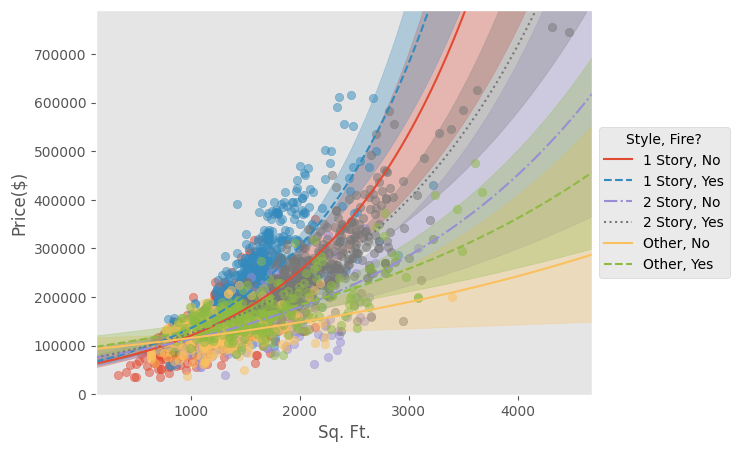

In [29]:
handle_plot(full_model.plot(confidence_band=alpha_val, figsize=(8,5)), name="full_model_output")

In [30]:
new_data = data.head()
print_dataframe(full_model.predict(new_data), name="full_model_predictions")

\begin{tabular}{lr}
\toprule
{} &  Predicted log(Price(\$)) \\
\midrule
0 &                    11.82 \\
1 &                    11.94 \\
2 &                    12.00 \\
3 &                    13.00 \\
4 &                    12.00 \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


In [31]:
print_dataframe(full_model.predict(new_data, prediction_interval=alpha_val), name="full_model_predictions_interval")

\begin{tabular}{lrrr}
\toprule
{} &  Predicted log(Price(\$)) &  2.5\% &  97.5\% \\
\midrule
0 &                    11.82 & 11.36 &  12.29 \\
1 &                    11.94 & 11.48 &  12.41 \\
2 &                    12.00 & 11.54 &  12.47 \\
3 &                    13.00 & 12.53 &  13.47 \\
4 &                    12.00 & 11.53 &  12.46 \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


## Section 3

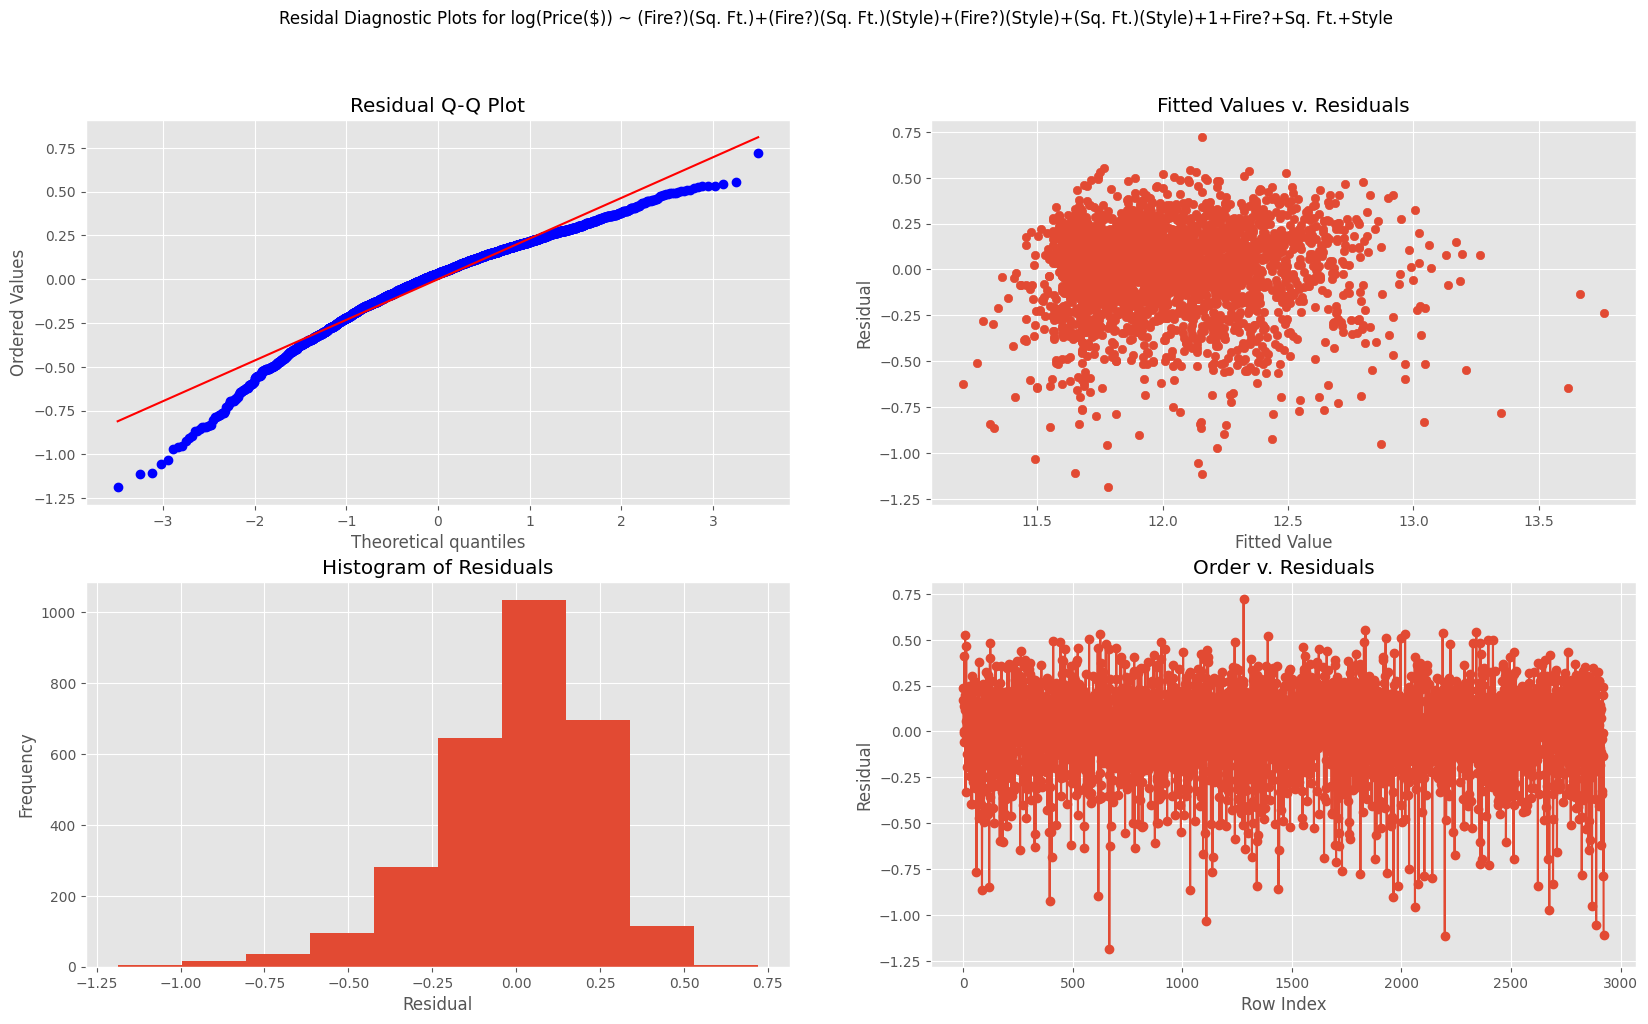

In [32]:
handle_plot(full_model.plot_residual_diagnostics(figsize=(20, 11))[0], name="full_model_resid_diagnostics")

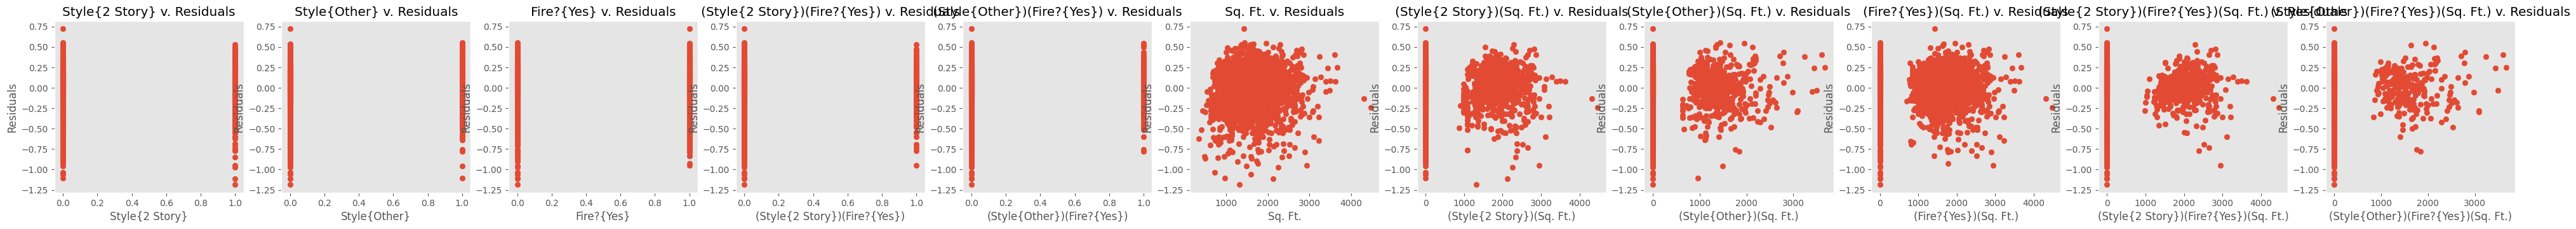

In [33]:
handle_plot(full_model.residual_plots(figsize=(50, 3.5))[0], name="full_model_residual_plots")

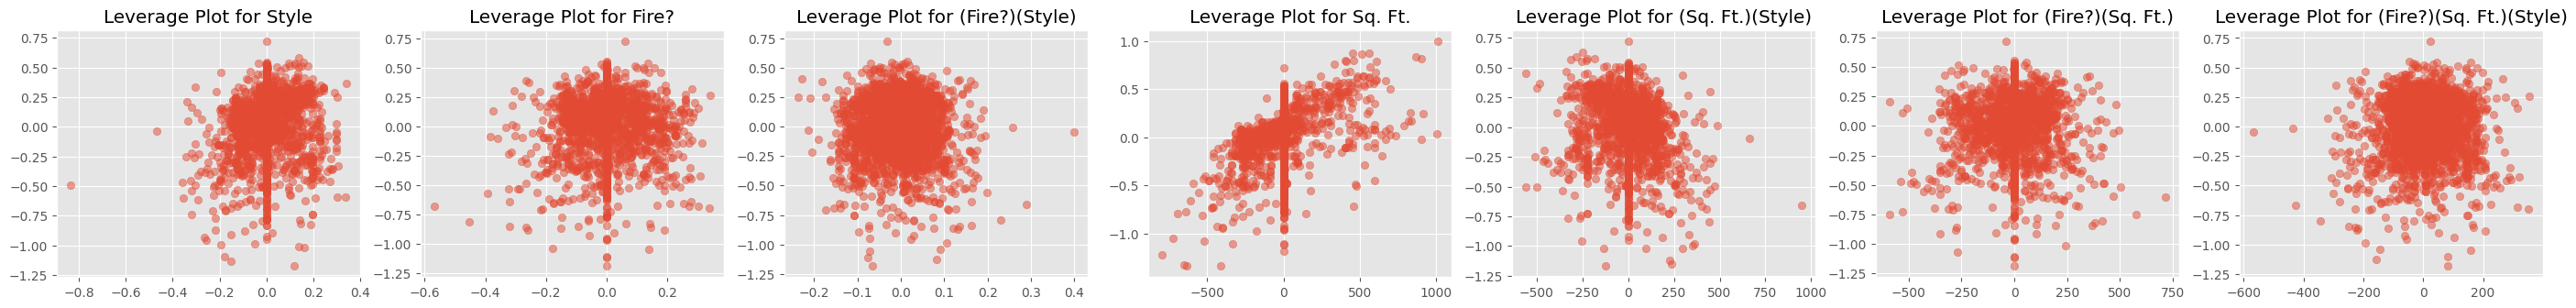

In [34]:
handle_plot(full_model.partial_plots(figsize=(35, 3.5))[0], name="full_model_partial_plots")

In [35]:
full_model.r_squared(adjusted=False)

LightDataFrame(0.65274838)

In [36]:
print_dataframe(anova(full_model), name="full_model_anova")

\begin{tabular}{lrllll}
\toprule
{} &    DF &             SS Err. &             SS Reg. &                   F &       p \\
\midrule
Global Test               &    11 &   309.5781289058364 &   309.5781289058364 &  500.76535612020103 &   0.000 \\
- Style                   &     2 &  166.77676145461203 &   306.4584031459668 &  27.755120255523824 & 1.1e-12 \\
- Fire?                   &     1 &   163.7319917200029 &  309.50317288057596 &  1.3337156244574375 &  0.2482 \\
- (Fire?)(Style)          &     2 &   163.6990211339245 &   309.5361434666544 &  0.3735299199911962 &  0.6883 \\
- Sq. Ft.                 &     1 &  200.26332829354106 &   272.9718363070378 &   651.3470294459581 &  8e-130 \\
- (Sq. Ft.)(Style)        &     2 &  169.81984169696096 &   303.4153229036179 &   54.82835187096356 & 4.2e-24 \\
- (Fire?)(Sq. Ft.)        &     1 &  163.79625254387446 &   309.4389120567044 &    2.47712823925653 &  0.1156 \\
- (Fire?)(Sq. Ft.)(Style) &     2 &  163.72162546077865 &   309.5135391398002

<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


In [37]:
print_dataframe(anova(full_model, quant_cat_model), name="anova_comparison")

\begin{tabular}{lrllll}
\toprule
{} &    DF &             SS Err. &            SS Reg. &                   F &       p \\
\midrule
Full Model      &    11 &  163.65703569474243 &  309.5781289058364 &                     &         \\
- Reduced Model &     5 &  179.01554838100844 &  294.2196162195704 &  54.655748532347886 & 2.0e-54 \\
Error           &  2912 &                     &                    &                     &         \\
\bottomrule
\end{tabular}



<ipython-input-3-fde64800d550>:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_output = df.to_latex()


## Section 4

In [38]:
quant_vars = Poly(Cen(Q("Sq. Ft.")), 2)
all_terms_model = LinearModel(
    (1 +  C("Style")) * (1 +  C("Fire?")) * (1 + quant_vars),
    Log(Q("Price($)")))
print(all_terms_model)

log(Price($)) ~ (Fire?)(Sq. Ft.-E(Sq. Ft.))+(Fire?)(Sq. Ft.-E(Sq. Ft.))(Style)+(Fire?)(Sq. Ft.-E(Sq. Ft.)^2)+(Fire?)(Sq. Ft.-E(Sq. Ft.)^2)(Style)+(Fire?)(Style)+(Sq. Ft.-E(Sq. Ft.))(Style)+(Sq. Ft.-E(Sq. Ft.)^2)(Style)+1+Fire?+Sq. Ft.-E(Sq. Ft.)+Sq. Ft.-E(Sq. Ft.)^2+Style


In [39]:
results = stepwise(
    full_model=all_terms_model,
    metric_name="BIC",
    forward=True,
    naive=True,
    data=data,
    verbose=False,
)

print(results["metric"])
print(results["best_model"])

BIC | -168.69617383126013
log(Price($)) ~ (Fire?)(Sq. Ft.-E(Sq. Ft.))+(Fire?)(Sq. Ft.-E(Sq. Ft.)^2)(Style)+(Sq. Ft.-E(Sq. Ft.))(Style)+1+Fire?+Sq. Ft.-E(Sq. Ft.)+Sq. Ft.-E(Sq. Ft.)^2+Style


In [40]:
smart_results = stepwise(
    full_model=all_terms_model,
    metric_name="BIC",
    forward=True,
    naive=False,
    data=data,
    verbose=True,
)

print(smart_results["metric"])
print(smart_results["best_model"])

log(Price($)) ~ 1+Sq. Ft.-E(Sq. Ft.)
BIC | 851.1311153911398
Current best potential model

log(Price($)) ~ 1+Fire?
BIC | 2074.947470480606
Not current best potential

log(Price($)) ~ 1+Style
BIC | 2760.491300235989
Not current best potential

!!! New model found. Now including Sq. Ft.-E(Sq. Ft.)

log(Price($)) ~ 1+Sq. Ft.-E(Sq. Ft.)+Sq. Ft.-E(Sq. Ft.)^2
BIC | 777.2449022638317
Current best potential model

log(Price($)) ~ 1+Fire?+Sq. Ft.-E(Sq. Ft.)
BIC | 555.9785969186938
Current best potential model

log(Price($)) ~ 1+Sq. Ft.-E(Sq. Ft.)+Style
BIC | 462.71861926533956
Current best potential model

!!! New model found. Now including Style

log(Price($)) ~ (Sq. Ft.-E(Sq. Ft.))(Style)+1+Sq. Ft.-E(Sq. Ft.)+Style
BIC | 167.77988022300798
Current best potential model

log(Price($)) ~ 1+Sq. Ft.-E(Sq. Ft.)+Sq. Ft.-E(Sq. Ft.)^2+Style
BIC | 351.5758987923416
Not current best potential

log(Price($)) ~ 1+Fire?+Sq. Ft.-E(Sq. Ft.)+Style
BIC | 199.01983105282147
Not current best potential

!!! New m

In [41]:
terms = (1 +  C("Style")) * (1 +  C("Fire?")) * (1 + quant_vars)
print(terms)

(Fire?)(Sq. Ft.-E(Sq. Ft.))+(Fire?)(Sq. Ft.-E(Sq. Ft.))(Style)+(Fire?)(Sq. Ft.-E(Sq. Ft.)^2)+(Fire?)(Sq. Ft.-E(Sq. Ft.)^2)(Style)+(Fire?)(Style)+(Sq. Ft.-E(Sq. Ft.))(Style)+(Sq. Ft.-E(Sq. Ft.)^2)(Style)+1+Fire?+Sq. Ft.-E(Sq. Ft.)+Sq. Ft.-E(Sq. Ft.)^2+Style


In [42]:
[(str(term), (C("Style") * Cen(Q("Sq. Ft."))).contains(term)) for term in (terms - C("Style") - Cen(Q("Sq. Ft."))).terms]

[('(Fire?)(Sq. Ft.-E(Sq. Ft.))(Style)', False),
 ('(Fire?)(Sq. Ft.-E(Sq. Ft.))', False),
 ('(Sq. Ft.-E(Sq. Ft.))(Style)', True),
 ('(Fire?)(Sq. Ft.-E(Sq. Ft.)^2)(Style)', False),
 ('(Fire?)(Sq. Ft.-E(Sq. Ft.)^2)', False),
 ('(Sq. Ft.-E(Sq. Ft.)^2)(Style)', False),
 ('Sq. Ft.-E(Sq. Ft.)^2', False),
 ('(Fire?)(Style)', False),
 ('Fire?', False),
 ('1', False),
 ('0*Sq. Ft.-E(Sq. Ft.)', False)]

## Section 5

# Section 6

In [43]:
import pandas as pd
import os
from salmon import *
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
from tabulate import tabulate
import numpy as np
import cProfile
%load_ext rpy2.ipython

In [44]:
if not os.path.isdir("data"):
    os.mkdir("data")
if not os.path.isfile("data/harris.csv"):
    import urllib.request
    urllib.request.urlretrieve("https://raw.githubusercontent.com/ajboyd2/salmon/master/data/harris.csv", "data/harris.csv")

In [45]:
data = pd.read_csv("data/harris.csv")

In [46]:
%%R
data_r <- read.csv("data/harris.csv")

In [47]:
nums = np.random.randint(0,50000,size=(10000,1000))
data2 = pd.DataFrame(nums)
y = data2.loc[:,0]
X = data2.iloc[:,1:]
cols = data2.columns

In [48]:
%R -i data2,cols colnames(data2) <- unlist(cols);
%R rdf <- data.frame(data2);
%R y = rdf$X0
%R X = data.matrix(rdf[,-1])

/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


array([[ 8125, 28321, 21991, ..., 33682,   521, 19112],
       [24622, 14138, 10200, ..., 22996,  7304, 16869],
       [35531, 27347, 32425, ...,  3430, 21092,  6685],
       ...,
       [16094,  3410, 39984, ..., 38103, 33366, 41614],
       [ 2812, 43316, 44283, ..., 31237, 16055, 31626],
       [46548, 37153, 11448, ..., 43552, 11262, 14591]], dtype=int32)

In [49]:
## salmon fit data
start_time = time.time()
explanatory = Q("Bsal")
response = Q("Sal77")
salmon_model = LinearModel(explanatory, response)
salmon_model.fit(data)
end_time = time.time()
elapsed_time_fit_sal = (end_time - start_time) * 1000

## statsmodels fit data
start_time = time.time()
statsmodels_results = smf.ols("Sal77 ~ Bsal", data=data).fit()
statsmodels_results.summary()
end_time = time.time()
elapsed_time_fit_sm = (end_time - start_time) * 1000

## salmon predict
start_time = time.time()
salmon_model.predict(data)
end_time = time.time()
elapsed_time_pred_sal = (end_time - start_time) * 1000

## statsmodels predict
start_time = time.time()
statsmodels_results.predict(data)
end_time = time.time()
elapsed_time_pred_sm = (end_time - start_time) * 1000

## salmon fit data2
start_time = time.time()
explanatory2 = C("Sex") + Q("Age") + Q("Exper") + Q("Senior") + Q("Bsal")
response2 = Q("Sal77")
salmon_model2 = LinearModel(explanatory2, response2)
salmon_model2.fit(data)
end_time = time.time()
elapsed_time_fit_sal2 = (end_time - start_time) * 1000

## statsmodels fit data2
start_time = time.time()
statsmodels_results2 = smf.ols("Sal77 ~ Sex + Age + Exper + Senior + Bsal", data=data).fit()
statsmodels_results2.summary()
end_time = time.time()
elapsed_time_fit_sm2 = (end_time - start_time) * 1000

## salmon predict2
start_time = time.time()
salmon_model2.predict(data)
end_time = time.time()
elapsed_time_pred_sal2 = (end_time - start_time) * 1000

## statsmodels predict2
start_time = time.time()
statsmodels_results2.predict(data)
end_time = time.time()
elapsed_time_pred_sm2 = (end_time - start_time) * 1000

## salmon fit data3
start_time = time.time()
explanatory3 = C("Sex") + Q("Bsal") +  Q("Exper") + C("Sex") * Q("Bsal") + C("Sex") * Q("Exper")
response3 = Q("Sal77")
salmon_model3 = LinearModel(explanatory3, response3)
salmon_model3.fit(data)
end_time = time.time()
elapsed_time_fit_sal3 = (end_time - start_time) * 1000

## statsmodels fit data3
start_time = time.time()
statsmodels_results3 = smf.ols('Sal77 ~ Sex + Bsal + Exper + Sex*Bsal + Sex*Exper', data=data).fit()
statsmodels_results3.summary()
end_time = time.time()
elapsed_time_fit_sm3 = (end_time - start_time) * 1000

## salmon predict3
start_time = time.time()
salmon_model3.predict(data)
end_time = time.time()
elapsed_time_pred_sal3 = (end_time - start_time) * 1000

## statsmodels predict3
start_time = time.time()
statsmodels_results3.predict(data)
end_time = time.time()
elapsed_time_pred_sm3 = (end_time - start_time) * 1000

# salmon fit data4
y = data2.loc[:,0]
X = data2.iloc[:,1:]
start_time = time.time()
salmon_model4 = LinearModel(X, y)
salmon_model4.fit()
end_time = time.time()
elapsed_time_fit_sal4 = (end_time - start_time) * 1000

## statsmodels fit data4
start_time = time.time()
statsmodels_results4 = sm.OLS(y, X).fit()
statsmodels_results4.summary()
end_time = time.time()
elapsed_time_fit_sm4 = (end_time - start_time) * 1000

# salmon predict4
start_time = time.time()
salmon_model4.predict(data2)
end_time = time.time()
elapsed_time_pred_sal4 = (end_time - start_time) * 1000

## statsmodels predict4
start_time = time.time()
statsmodels_results4.predict(X)
end_time = time.time()
elapsed_time_pred_sm4 = (end_time - start_time) * 1000

In [50]:
%%R

## R fit data
start_time = Sys.time()
R_model = lm("Sal77 ~ Bsal", data=data_r)
summary(R_model)
end_time = Sys.time()
elapsed_time_fit_r = (end_time - start_time) * 1000

## R predict
start_time = Sys.time()
predict(R_model)
end_time = Sys.time()
elapsed_time_pred_r = (end_time - start_time) * 1000

# R fit data2
start_time = Sys.time()
R_model2 = lm("Sal77 ~ Sex + Age + Exper + Senior + Bsal", data=data_r)
summary(R_model2)
end_time = Sys.time()
elapsed_time_fit_r2 = (end_time - start_time) * 1000

## R predict2
start_time = Sys.time()
predict(R_model2)
end_time = Sys.time()
elapsed_time_pred_r2 = (end_time - start_time) * 1000

# R fit data3
start_time = Sys.time()
R_model3 = lm("Sal77 ~ Sex + Bsal + Exper + Sex*Bsal + Sex*Exper", data=data_r)
summary(R_model3)
end_time = Sys.time()
elapsed_time_fit_r3 = (end_time - start_time) * 1000

## R predict3
start_time = Sys.time()
predict(R_model3)
end_time = Sys.time()
elapsed_time_pred_r3 = (end_time - start_time) * 1000

# R fit data4
start_time = Sys.time()
R_model4 = lm("y ~ .", data=rdf)
summary(R_model)
end_time = Sys.time()
elapsed_time_fit_r4 = (end_time - start_time) * 1000

## R predict4
start_time = Sys.time()
predict(R_model4)
end_time = Sys.time()
elapsed_time_pred_r4 = (end_time - start_time) * 1000

In [51]:
elapsed_time_fit_r = %Rget elapsed_time_fit_r
elapsed_time_pred_r = %Rget elapsed_time_pred_r
elapsed_time_fit_r2 = %Rget elapsed_time_fit_r2
elapsed_time_pred_r2 = %Rget elapsed_time_pred_r2
elapsed_time_fit_r3 = %Rget elapsed_time_fit_r3
elapsed_time_pred_r3 = %Rget elapsed_time_pred_r3
elapsed_time_fit_r4 = %Rget elapsed_time_fit_r4
elapsed_time_pred_r4 = %Rget elapsed_time_pred_r4

table = [
["Fit",  elapsed_time_fit_sal, elapsed_time_fit_sm, elapsed_time_fit_r[0]],
["Predict", elapsed_time_pred_sal, elapsed_time_pred_sm, elapsed_time_pred_r[0]],
["Fit2",  elapsed_time_fit_sal2, elapsed_time_fit_sm2, elapsed_time_fit_r2[0]],
["Predict2", elapsed_time_pred_sal2, elapsed_time_pred_sm2, elapsed_time_pred_r2[0]],
["Fit3",  elapsed_time_fit_sal3, elapsed_time_fit_sm3, elapsed_time_fit_r3[0]],
["Predict3", elapsed_time_pred_sal3, elapsed_time_pred_sm3, elapsed_time_pred_r3[0]],
["Fit4",  elapsed_time_fit_sal4, elapsed_time_fit_sm4, elapsed_time_fit_r4[0]],
["Predict4", elapsed_time_pred_sal4, elapsed_time_pred_sm4, elapsed_time_pred_r4[0]],
]
print (tabulate(table, headers=["Test", "Salmon", "statsmodels", "R"]))

Test           Salmon    statsmodels           R
--------  -----------  -------------  ----------
Fit          3.1395         11.7795     19.14
Predict      0.725269        3.30591     2.62237
Fit2         6.18148        15.3577      6.44612
Predict2     1.50371         5.8043      1.23453
Fit3         5.81574        12.9337      2.77495
Predict3     4.28033         4.39906     1.04833
Fit4      3005.9         11074.2      7857.94
Predict4   219.29           39.2435    392.585


### Generate Data


In [52]:
np.random.seed(1)
n = 100
x = np.random.randn(n) + 1e8
y = 2 + 2 * x + np.random.randn(n)
df = pd.DataFrame({
    "x": x,
    "y": y
})

#### Salmon


In [53]:
model = LinearModel(Q("x"), Q("y"))
model.fit(df)

,Coefficient,SE,t,p,2.5%,97.5%
x,2.095,0.1059,19.78,5.4e-36,1.885,2.306
Intercept,-9.543e+6,1.059e+7,-0.9009,0.3698,-3.056e+7,1.148e+7


#### Statsmodels


In [54]:
smf.ols("y ~ x", df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 09 Oct 2023   Prob (F-statistic):                nan
Time:                        06:42:48   Log-Likelihood:                -134.85
No. Observations:                 100   AIC:                             271.7
Df Residuals:                      99   BIC:                             274.3
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept       2e-08   9.37e-18   2.14e+09      0.000       2e-08       2e-08
x              2.0000   9.37e-10   2.14e+09      0.000       2.000       2.000
==============================================================================
Omnibus:                        1.029   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.598   Jarque-Bera (JB):                0.617
Skew:                          -0.167   Prob(JB):                        0.734
Kurtosis:                       3.191   Cond. No.                     1.13e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.84e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### R


In [56]:
%%R -i df

summary(lm(y ~ x, data = df))


Call:
lm(formula = y ~ x, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9633 -1.2277  0.1418  1.2327  6.2879 

Coefficients: (1 not defined because of singularities)
             Estimate Std. Error   t value Pr(>|t|)    
(Intercept) 2.000e+08  2.085e-01 959462622   <2e-16 ***
x                  NA         NA        NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.085 on 99 degrees of freedom



/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


# Appendix A.1

# Appendix B.1

# Appendix B.2